In [139]:
# load libraries
import matplotlib.pyplot as plt
import matplotlib
import multiprocessing as mp 
import numpy as np
import pandas as pd
import os
import scipy
import scipy.io as sio
import scipy.signal as sig
import scipy.stats as stat
import zipfile
from tvb.simulator.plot.tools import *
from tvb.simulator.lab import *
from tvb.simulator.models.wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI
from tvb.datatypes.time_series import TimeSeriesRegion
from tvb.analyzers import fmri_balloon
import tvb.analyzers.correlation_coefficient as corr_coeff
LOG = get_logger('BrainTumor')
# from tvb.analyzers.fcd_matrix import FcdCalculator

# Introduction  
We simulated large-scale brain dynamics using The Virtual Brain, an open-source neuroinformatics platform.  
Local and global model parameters of the Reduced Wong-Wang model were individually optimized.  
<br>
Original publication can be found here: https://www.eneuro.org/content/5/3/ENEURO.0083-18.2018  
<br>
When using The Virtual Brain for scientific publications, please cite it as follows:  
<pre><code>Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide,
Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013)
    The Virtual Brain: a simulator of primate brain network dynamics.
Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010)</code></pre>
![](images/workflow.png?raw=true)

In [4]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


## Load Individual Structural Connectivity

In [41]:
def load_connectivity(input_name):
    # TODO: remove hard coded path parameters
    zip_file_name = input_name + "_TVB.zip"
    dir_name = input_name + "_TVB"
    zip_path = "TVB_input/" + input_name + "/" + zip_file_name
    dir_path = "TVB_input/" + input_name + "/" + dir_name
    # Load the connectivity data
    conn = connectivity.Connectivity.from_file(zip_path)
    # Configure, to compute derived data, such as number_of_nodes and delays
    conn.configure()
    # conn.summary_info
    
    # Compare weight
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir_path)
    weight_txt = np.loadtxt(fname = dir_path + "/weights.txt")
    # Load the structural connectivity matrix from matlab file
    SC_path = "TVB_input/" + input_name + "/SCthrAn.mat"
    x = sio.loadmat(SC_path)
    assert(np.allclose(x['SCthrAn'], weight_txt), "Two weights should be the same")
    return conn

<IPython.core.display.Javascript object>


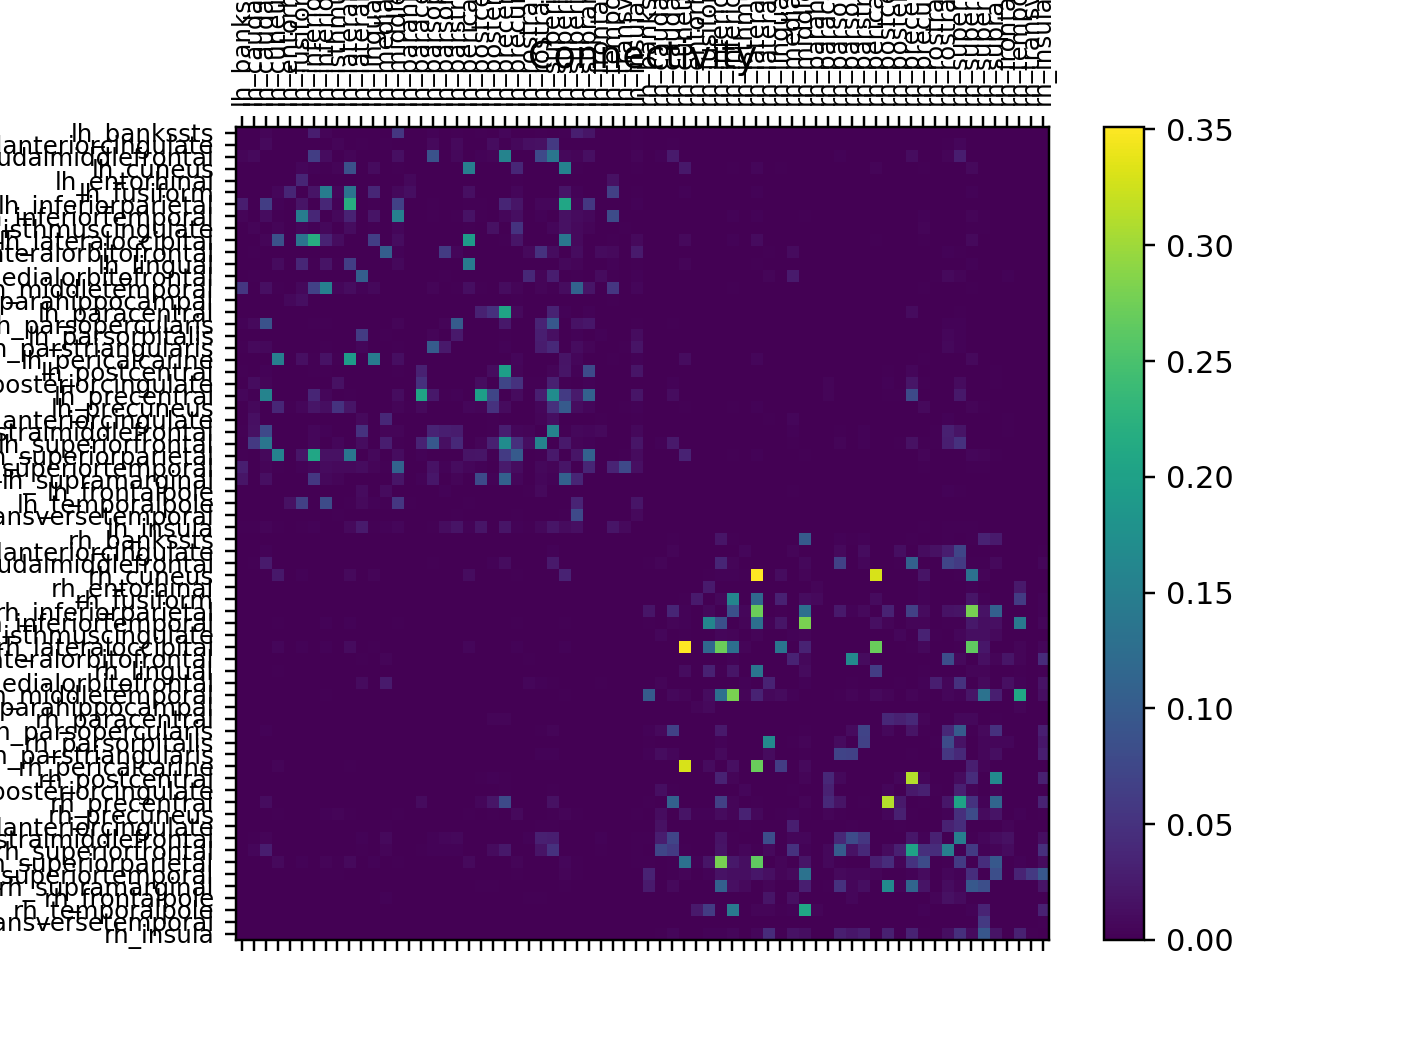

<IPython.core.display.Javascript object>


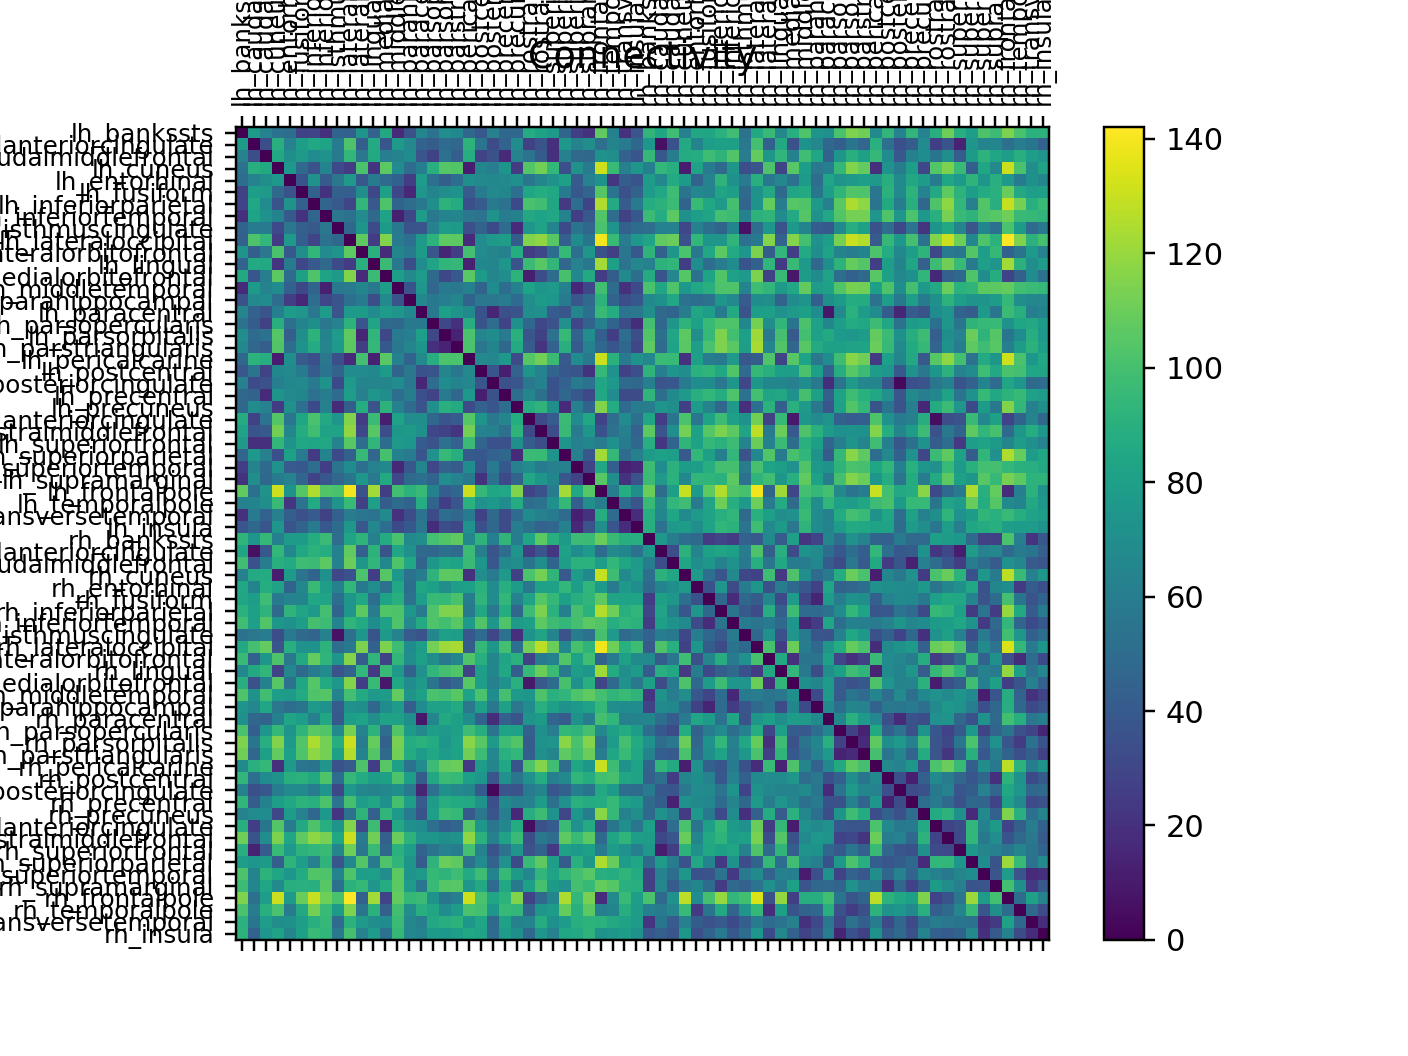

In [214]:
dir_name = "TVB_input/"
dir_list = [f for f in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, f)) ]
# Load the connectivity data
# for input_name in dir_list:
# input_name = "CON02T1"
input_name = "PAT01T1"
conn = load_connectivity(input_name)
conn.configure()
# Print and Plot Structural Connectivity Info
conn.summary_info
plot_connectivity(connectivity = conn)

## Configure Simulator

In [222]:
# Reduced Wong-Wang model with with an excitatory and an inhibitory population, mutually coupled.
# Following Deco et al 2014.
rww = ReducedWongWangExcIOInhI(J_i=2.0, lamda=0, G=1.5, a_e=310, b_e=125, d_e=0.16, 
                               gamma_e=0.000641, tau_e=100, w_p=1.4, 
                               J_N=0, W_e=1.0, a_i=615, b_i=177, d_i=0.087, 
                               tau_i=10, gamma_i=0.001, W_i=0.7, I_o=0.382,
                              state_variable_range={'S_e': [3.0, 3.0], 'S_i': [3.0, 3.0]})

<IPython.core.display.Javascript object>


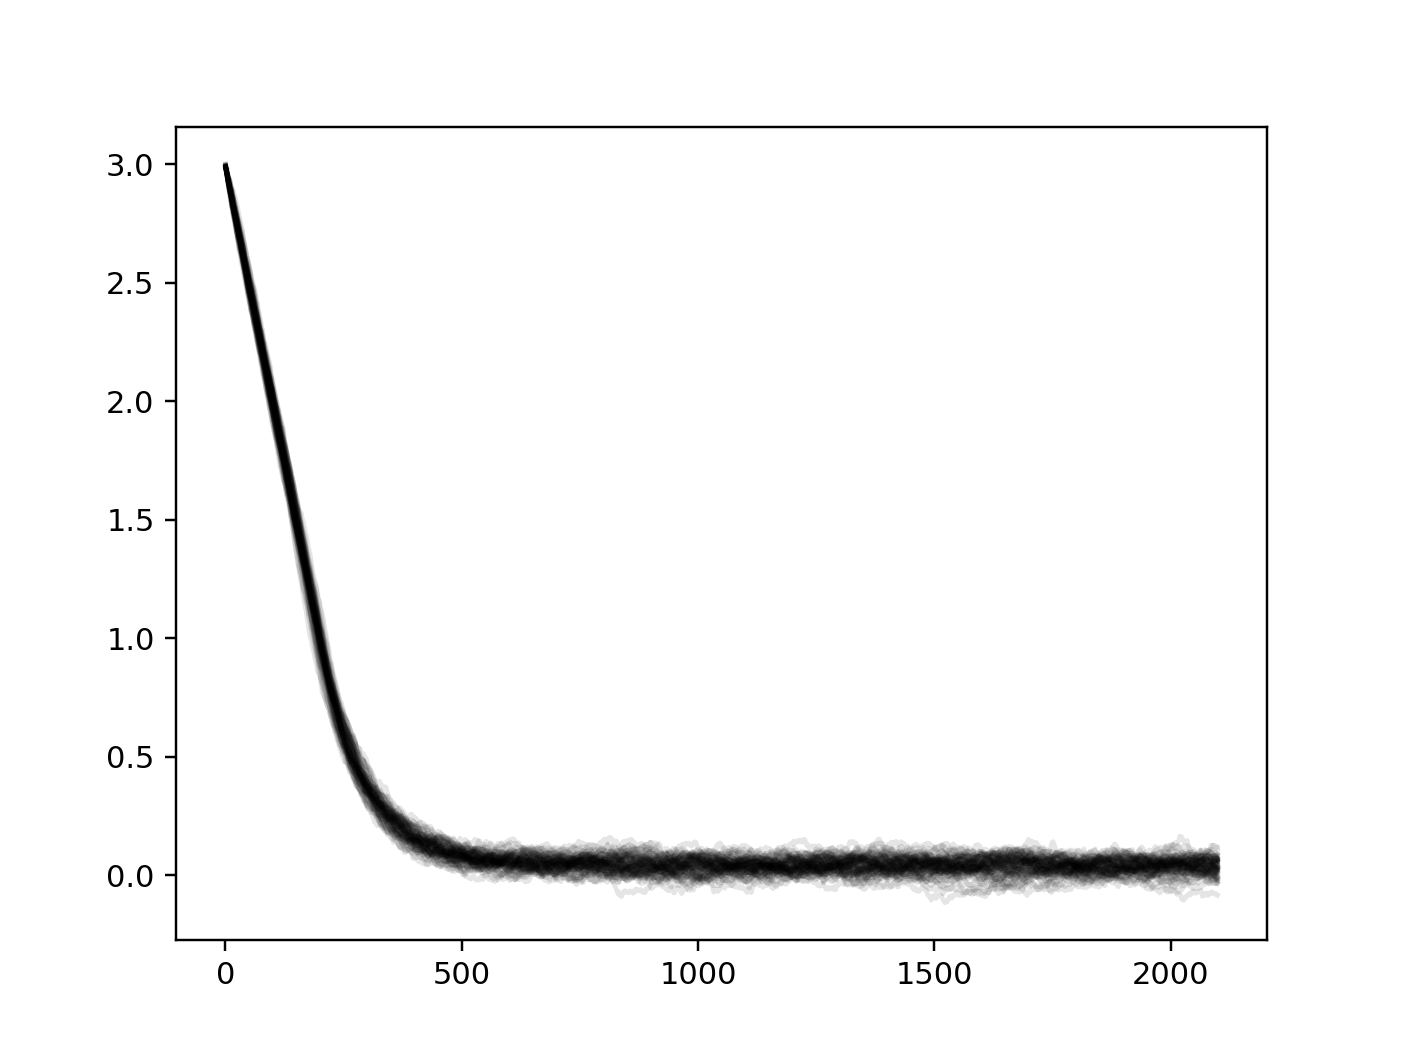

In [223]:
# set up the simulator
# adjust the simulation_length to your needs/ available computation time
# a simulation_length of 2100 or 2400 was used
sim = simulator.Simulator(
    model=rww,
    connectivity=conn,
    coupling=coupling.Linear(a=0.5 / 50.0),
    integrator=integrators.EulerStochastic(dt=1, noise=noise.Additive(nsig=1e-5)), 
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=1)
    ),
    simulation_length=2100
).configure()

sim.coupling.a=0.01
(tavg_time, tavg_data), (bold_time, bold_data) = sim.run()

figure()
plot(tavg_time, tavg_data[:, 0, :, 0], 'k', alpha=0.1);

In [224]:
# upper index
uidx = np.triu_indices(68, 1)
# get empirical functional connectivity
em_fc_matrix = sio.loadmat('TVB_input/PAT01T1/FC.mat')['FC_cc_DK68']
em_fc_z = arctanh(em_fc_matrix)
# em_fc = em_fc_z[uidx]
em_fc = em_fc_matrix[uidx]

## Run Simulation

In [225]:
def run_sim(global_coupling):
    sim.coupling.a = global_coupling

    (tavg_time, tavg_data), (bold_time, bold_data) = sim.run()
    
    # For the analyzer, we build a time series object,
    tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=bold_data,
                       sample_period=sim.monitors[1].period)
    tsr.configure()

    # Simulated FC
    corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
    corrcoeff_data = corrcoeff_analyser.evaluate()
    corrcoeff_data.configure()
    FC = corrcoeff_data.array_data[..., 0, 0]
    # sim_fc = arctanh(FC)[uidx]
    sim_fc = FC[uidx]
    ## Calculate correlation
    pearson_corr, _ = stat.pearsonr(sim_fc, em_fc)

    return (global_coupling, pearson_corr)

In [226]:
# define global coupling range to explore in simulation
# in the original study a range from 0.01 to 3 with steps of 0.015 was explored
gc_range = np.arange(0.01, 3, 0.015)
# run simulation in parallel - be sure that your computer has enough cores
n_cores = 4 # specify number of cores which should be used in parallel 
p = mp.Pool(processes=n_cores)
results = p.map(run_sim, gc_range)
p.close()

<IPython.core.display.Javascript object>


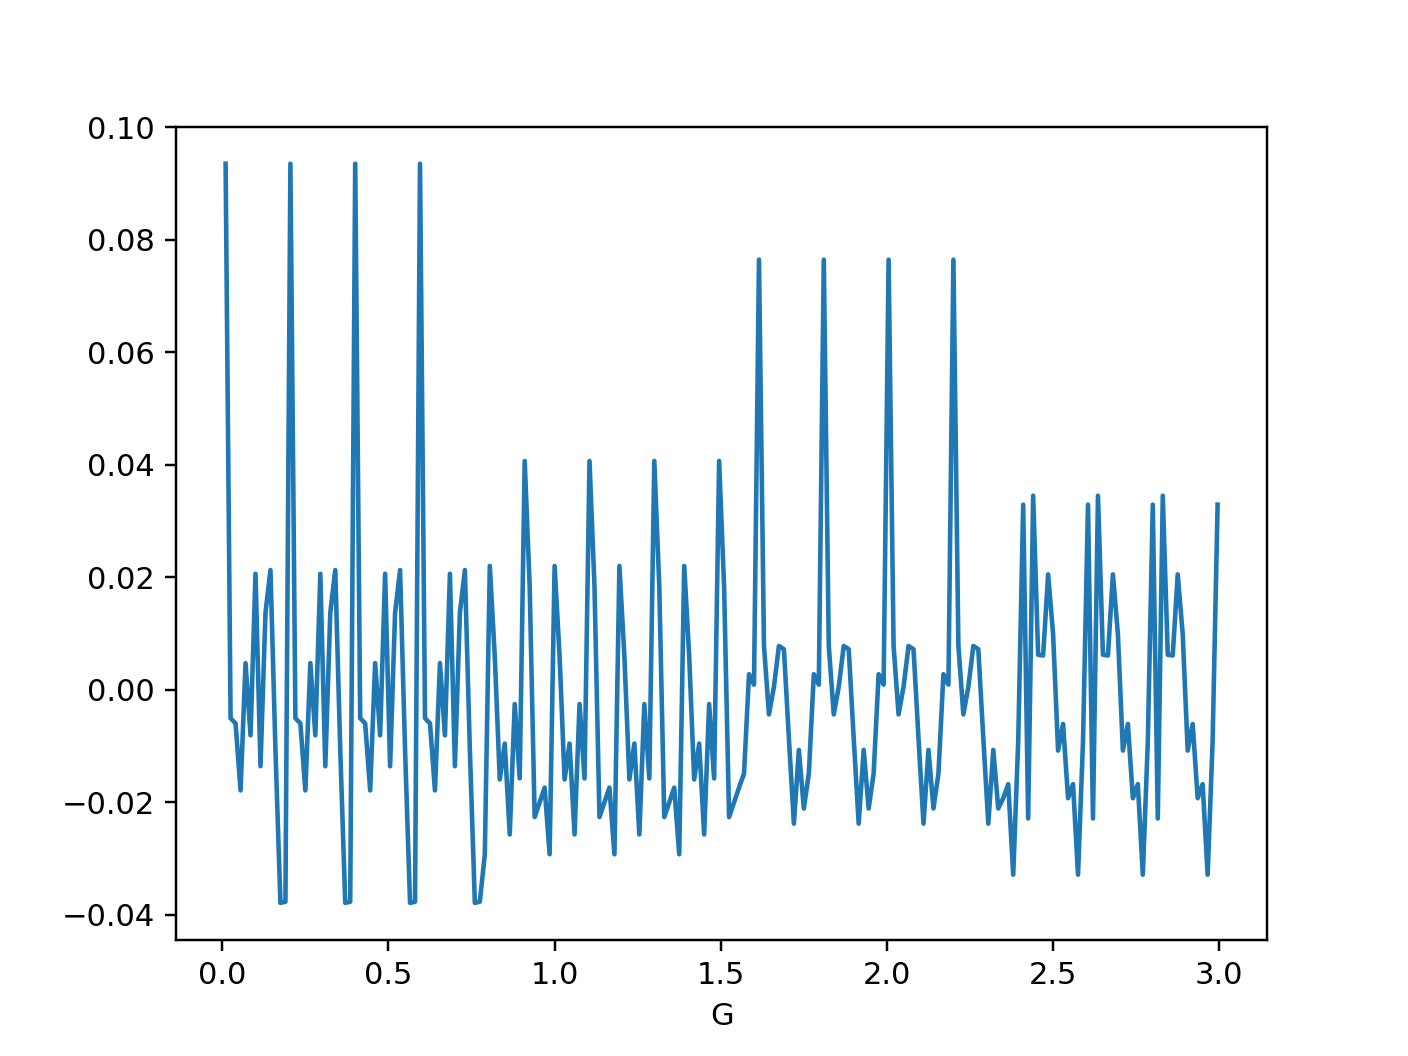

Text(0.5,0,'G')

In [231]:
g = []
PCorr = []
for result in results:
    g.append(result[0])
    PCorr.append(result[1])
plot(g, PCorr)
pyplot.xlabel('G')

In [228]:
PCorr.index(max(PCorr))

0

In [71]:
g[7]

0.115

# Utilities  

### Pearson Correlation

In [140]:
# Compute Pearson's correlation coefficient
# Can be substituted by scipy.stat.pearsonr
def corr(x, y, n):
    mx = 0
    my = 0
    
    # Calculate the mean of the two series x[], y[] 
    for i in range(0, n):
        mx += x[i]
        my += y[i]

    mx = mx/n;
    my = my/n;
    
    # Calculate the correlation 
    sxy = 0
    sxsq = 0
    sysq = 0
    for i in range(0, n):
        tmpx = x[i] - mx;
        tmpy = y[i] - my;
        sxy = tmpx*tmpy + sxy;
        sxsq = tmpx*tmpx + sxsq;
        sysq = tmpy*tmpy + sysq;
    
    return (sxy / (sqrt(sxsq)*sqrt(sysq)));